In [1]:
import ee 
import pandas as pd
import numpy as np
from ee_jupyter.ipyleaflet import Map
import ipyleaflet as ipl
from ipywidgets import Layout
import json

# ee.Authenticate()
ee.Initialize()

准备数据集: 
- Clouds
- Precipitation
- Pollution

In [2]:
clouds=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD")
precipitation=ee.ImageCollection("NASA/GPM_L3/IMERG_V06")
nox=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
sox=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2")

with open(r'../shp/china.json','r') as f:
    china = json.load(f)
china_fc = ee.FeatureCollection(china)
china_img = ee.Image().paint(china_fc, 0, 1)

start_year = 2019
end_year = 2022

In [42]:
def export_monthly_means(image_collection,band, region, start_year, end_year, folder):
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, 'month')
            monthly_mean = image_collection.filterDate(start_date, end_date).select(band).mean().clip(region)
            
            # 导出代码
            export(region, folder, year, month, monthly_mean)

import time

def export(image, region, year, month, folder):
    task = ee.batch.Export.image.toDrive(
                image=image,
                folder=folder,
                description=f'monthly_mean_{year}_{month}',
                scale=5000,
                region=region.geometry()
            )
    task.start()
    print(f'Exporting monthly mean {year}-{month}...')
    i=0
    while task.active():
        time.sleep(5)
        print(f'Running for {i*5} seconds...')
        i+=1
    print(f'Exporting monthly mean {year}-{month} complete!')


让我试试能否在python里面直接操作GoogleDrive,这样就省的直接打开网页了

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os
 
# 访问GoogleAPI的科学上网端口
import socks
import socket
socks.set_default_proxy(socks.PROXY_TYPE_HTTP, "127.0.0.1", 7890)
socket.socket = socks.socksocket

 
gauth = GoogleAuth()
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=1039998094623-887jbtiju3t7obkgp48rov3p0iud9g1i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


上述过程的实现有点复杂, 主要参考了这篇文章https://zhuanlan.zhihu.com/p/460253892#:~:text=%E5%A6%82%E4%BD%95%E4%BB%8EGoogle%20Drive%E6%96%87%E4%BB%B6%E5%A4%B9%E6%89%B9%E9%87%8F%E8%87%AA%E5%8A%A8%E5%8C%96%E4%B8%8B%E8%BD%BD%E5%A4%A7%E6%96%87%E4%BB%B6%201%20Step%201%EF%BC%9A%E5%90%AF%E7%94%A8Google%20Drive%20API%20%E5%8F%82%E8%80%83,4%20Step%204%EF%BC%9A%E7%9C%8B%E6%B3%A8%E9%87%8A%E4%BF%AE%E6%94%B9%E4%B8%80%E4%BA%9B%E9%9B%B6%E9%9B%B6%E7%A2%8E%E7%A2%8E%EF%BC%8C%E7%94%A8%E4%BD%A0%E5%96%9C%E6%AC%A2%E7%9A%84%E5%A7%BF%E5%8A%BF%E6%89%A7%E8%A1%8C%E4%B8%8B%E9%9D%A2%E7%9A%84python%E8%84%9A%E6%9C%AC%E3%80%82%20...%205%20Step5%3A%20%E8%BF%90%E8%A1%8C%E8%84%9A%E6%9C%AC%E5%92%8CMD5%E6%A3%80%E9%AA%8C%20

总之, 想要重复使用的话, 记得把该文件夹下的client_secrets.json文件复制到对应脚本的文件夹下面, 从而使得代码可以进行访问

In [45]:
def create_folder(name):
    folder_list = drive.ListFile({'q': "'root' in parents and trashed=false and mimeType='application/vnd.google-apps.folder'"}).GetList()
    if name in [folder['title'] for folder in folder_list]:
        print(f'Folder \'{name}\'already exists')
    else:
        folder_metadata = {
            'title' : name,  # 文件夹名称
            'mimeType' : 'application/vnd.google-apps.folder'
        }
        folder = drive.CreateFile(folder_metadata)
        folder.Upload()

import os
from tqdm import tqdm
def download_files_in_folder_by_name(folder_name, destination_folder):
    # 查询并获取文件夹 ID
    folder_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    folder_id = folder_list[0]['id'] if folder_list else None

    if folder_id is None:
        print(f'Folder "{folder_name}" not found.')
        return

    # 确保目标文件夹存在
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # 列出并下载文件夹中的所有文件
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in tqdm(file_list, desc=f"Downloading files from '{folder_name}'"):
        file_path = os.path.join(destination_folder, file['title'])
        file.GetContentFile(file_path)
        print(f"Downloaded '{file['title']}' to '{destination_folder}'")
        
import requests
requests.packages.urllib3.disable_warnings()

names=['clouds_cn_2019_2022_monthly_mean', 'precipitation_cn_2019_2022_monthly_mean', 'nox_cn_2019_2022_monthly_mean', 'sox_cn_2019_2022_monthly_mean']
for name in names:
    create_folder(name)

Folder 'clouds_cn_2019_2022_monthly_mean'already exists
Folder 'precipitation_cn_2019_2022_monthly_mean'already exists
Folder 'nox_cn_2019_2022_monthly_mean'already exists
Folder 'sox_cn_2019_2022_monthly_mean'already exists


上方的import requests进行disable_warning的操作我也很莫名其妙, 但是这是从GPT的回答中得出来的最简便的方法.

In [16]:
test=clouds.filterDate('2019-01-01', '2019-02-01').mean().clip(china_fc).select('cloud_optical_depth')
map1=Map(center=[35, 110], zoom=4, layout=Layout(height='600px'), basemap=ipl.basemaps.Esri.WorldImagery)
map1.addLayer(test, {'min':0, 'max':50, 'palette':['blue','skyblue','white']}, 'test')
map1

Map(center=[35, 110], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [50]:
export(test, china_fc, 2019, 1, names[0])

Exporting monthly mean 2019-1...
Running for 0 seconds...
Running for 5 seconds...
Running for 10 seconds...
Running for 15 seconds...
Running for 20 seconds...
Running for 25 seconds...
Running for 30 seconds...
Running for 35 seconds...
Running for 40 seconds...
Running for 45 seconds...
Running for 50 seconds...
Running for 55 seconds...
Running for 60 seconds...
Running for 65 seconds...
Running for 70 seconds...
Running for 75 seconds...
Running for 80 seconds...
Running for 85 seconds...
Running for 90 seconds...
Running for 95 seconds...
Running for 100 seconds...
Running for 105 seconds...
Running for 110 seconds...
Running for 115 seconds...
Running for 120 seconds...
Running for 125 seconds...
Running for 130 seconds...
Running for 135 seconds...
Running for 140 seconds...
Running for 145 seconds...
Running for 150 seconds...
Running for 155 seconds...
Running for 160 seconds...
Running for 165 seconds...
Running for 170 seconds...
Running for 175 seconds...
Running for 180 s

In [53]:
download_files_in_folder_by_name(names[0], names[0])


Downloaded 'monthly_mean_2019_1.tif' to 'clouds_cn_2019_2022_monthly_mean'


In [54]:
import rasterio as rs

with rs.open('./clouds_cn_2019_2022_monthly_mean/monthly_mean_2019_1.tif', 'r') as f:
    band1 = f.read(1)


In [55]:

print(band1.shape)

(1118, 1372)


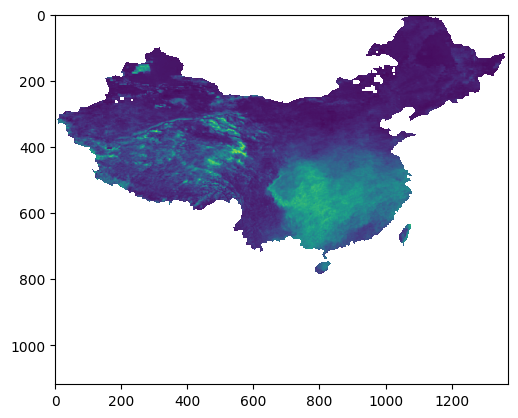

In [56]:
import matplotlib.pyplot as plt
plt.imshow(band1)

In [3]:
import time

# get basic data
clouds=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD")
precipitation=ee.ImageCollection("NASA/GPM_L3/IMERG_V06")
nox=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
sox=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2")

IC=[clouds,precipitation,nox,sox]
bands=[
    'cloud_optical_depth',
    'precipitationCal',
    'NO2_column_number_density',
    'SO2_column_number_density'
]
folders=['clouds_cn_2019_2022_monthly_mean', 'precipitation_cn_2019_2022_monthly_mean', 'nox_cn_2019_2022_monthly_mean', 'sox_cn_2019_2022_monthly_mean']

with open(r'../shp/china.json','r') as f:
    china = json.load(f)
china_fc = ee.FeatureCollection(china)
china_img = ee.Image().paint(china_fc, 0, 1)

start_year = 2020
end_year = 2022

# basic function
def export(image, region, year, month, folder):
    task = ee.batch.Export.image.toDrive(
                image=image,
                folder=folder,
                description=f'monthly_mean_{year}_{month}',
                scale=5000,
                region=region.geometry()
            )
    task.start()
    print(f'Exporting monthly mean {year}-{month} ...')
    i=0
    while task.active():
        time.sleep(5)
        print(f'{year}-{month}: Running for {i*5} seconds...')
        i+=1
    print(f'Exporting monthly mean {year}-{month} complete!\n{folder}\n')

def export_monthly_means(image_collection,band, region, start_year, end_year, folder,start_month=1,end_month=12):
    year=start_year
    month=start_month
    flag=(year<end_year) or ((year==end_year) and (month<=end_month)) 
    while flag:
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')
        monthly_mean = image_collection.filterDate(start_date, end_date).select(band).mean().clip(region)
        # 导出代码
        export(monthly_mean, region,  year, month, folder)
        month+=1
        if month>12:
            month=1
            year+=1
        flag=(year<end_year) or ((year==end_year) and (month<=end_month))


def download_files_in_folder_by_name(folder_name, destination_folder):
    # 查询并获取文件夹 ID
    folder_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    folder_id = folder_list[0]['id'] if folder_list else None

    if folder_id is None:
        print(f'Folder "{folder_name}" not found.')
        return

    # 确保目标文件夹存在
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # 列出并下载文件夹中的所有文件
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in tqdm(file_list, desc=f"Downloading files from '{folder_name}'"):
        file_path = os.path.join(destination_folder, file['title'])
        file.GetContentFile(file_path)
        print(f"Downloaded '{file['title']}' to '{destination_folder}'")

# export!
        
export_monthly_means(IC[1],bands[1],china_fc,start_year,end_year,folders[1])

Exporting monthly mean 2020-1 ...
2020-1: Running for 0 seconds...
2020-1: Running for 5 seconds...
2020-1: Running for 10 seconds...
2020-1: Running for 15 seconds...
2020-1: Running for 20 seconds...
2020-1: Running for 25 seconds...
2020-1: Running for 30 seconds...
2020-1: Running for 35 seconds...
2020-1: Running for 40 seconds...
2020-1: Running for 45 seconds...
2020-1: Running for 50 seconds...
2020-1: Running for 55 seconds...
2020-1: Running for 60 seconds...
2020-1: Running for 65 seconds...
2020-1: Running for 70 seconds...
2020-1: Running for 75 seconds...
2020-1: Running for 80 seconds...
2020-1: Running for 85 seconds...
2020-1: Running for 90 seconds...
2020-1: Running for 95 seconds...
2020-1: Running for 100 seconds...
2020-1: Running for 105 seconds...
2020-1: Running for 110 seconds...
2020-1: Running for 115 seconds...
2020-1: Running for 120 seconds...
2020-1: Running for 125 seconds...
2020-1: Running for 130 seconds...
2020-1: Running for 135 seconds...
2020-1: 

KeyboardInterrupt: 